Loaded data:                GWH_JUAL
Date                  
2015-01-01  201.535993
2015-02-01  184.068578
2015-03-01  205.282188
2015-04-01  205.318231
2015-05-01  214.088879


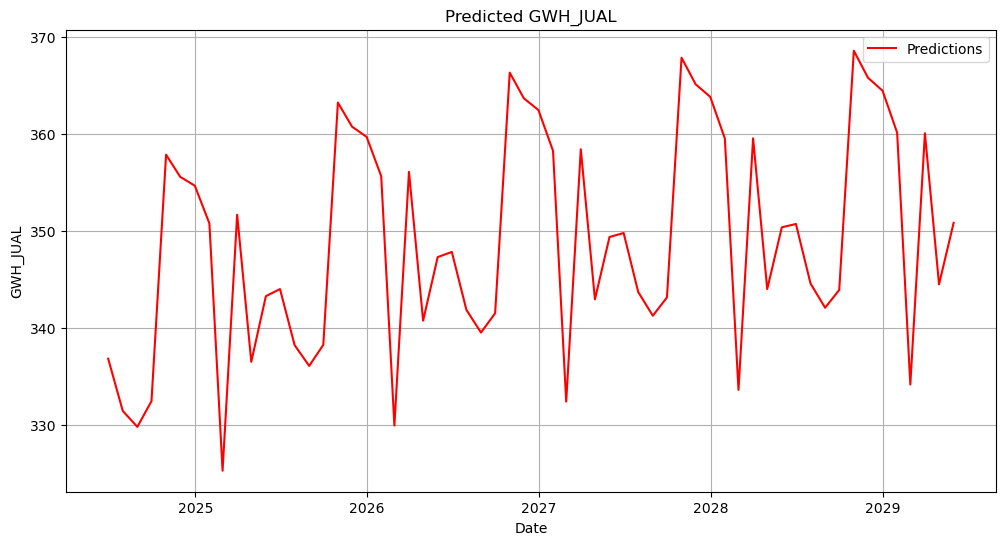

In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_size=1, hidden_size=8, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(in_features=8, out_features=1)

    def forward(self, x, hidden=None):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Take output from last time step
        return out, hidden

def load_data(csv_path):
    df = pd.read_csv(csv_path, delimiter=';')
    df['Date'] = pd.to_datetime(df['THBL'], format='%Y%m')
    df.set_index('Date', inplace=True)
    df.drop(columns=['THBL'], inplace=True)
    return df

class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_column, sequence_length):
        self.data = data
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.data_values = self.data[target_column].values

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data_values[idx:idx+self.sequence_length]
        y = self.data_values[idx+self.sequence_length]
        return torch.tensor(x, dtype=torch.float32).unsqueeze(1), torch.tensor(y, dtype=torch.float32)

def predict_long_term(model, data, sequence_length, device, months_ahead=60):
    model.eval()
    predictions = []

    with torch.no_grad():
        input_seq = data[-sequence_length:]  # Initial input sequence from the end of the data
        input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

        for _ in range(months_ahead):
            output, _ = model(input_seq)
            predictions.append(output.item())

            # Create new input sequence: remove first element and append the new prediction
            output = output.unsqueeze(0).unsqueeze(2) if output.dim() == 1 else output.view(1, 1, 1)
            input_seq = torch.cat((input_seq[:, 1:, :], output), dim=1)

    return predictions

def plot_predictions(data, preds, sequence_length):
    # Prepare dates for plotting (assuming a monthly frequency)
    start_date = data.index[-1] + pd.DateOffset(months=1)
    dates = pd.date_range(start=start_date, periods=len(preds), freq='M')

    # Plot predictions only
    plt.figure(figsize=(12, 6))
    plt.plot(dates, preds, label='Predictions', color='red')
    plt.title('Predicted GWH_JUAL')
    plt.xlabel('Date')
    plt.ylabel('GWH_JUAL')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    csv_path = 'data/JOG_monthly.csv'  # Path to the CSV file
    months_ahead = 60  # Number of months ahead to predict

    if not os.path.exists(csv_path):
        print("CSV file not found")
    else:
        try:
            data = load_data(csv_path)
            print("Loaded data: ", data.head())  # Logging for debugging

            # Apply MinMaxScaler to the data
            scaler = MinMaxScaler()
            scaled_data = scaler.fit_transform(data["GWH_JUAL"].values.reshape(-1, 1))

            # Decompose the data to get the seasonal component
            result = STL(data['GWH_JUAL'], seasonal=13).fit()
            seasonal_component = result.seasonal.values

            # Create dataset and dataloader
            sequence_length = 12  # Define your sequence length
            train_forecast_set = TimeSeriesDataset(pd.DataFrame(scaled_data, index=data.index, columns=["GWH_JUAL"]), "GWH_JUAL", sequence_length)
            trainforecastloader = DataLoader(train_forecast_set, batch_size=1, shuffle=False)

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = MyModel()
            model.load_state_dict(torch.load('model.pth', map_location=device))
            model.to(device)
            model.eval()

            # Perform long-term prediction
            preds_scaled = predict_long_term(model, scaled_data.flatten(), sequence_length, device, months_ahead=months_ahead)

            # Inverse transform the predictions
            preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

            # Add seasonal component to the predictions
            seasonal_component_forecast = np.tile(seasonal_component[-12:], months_ahead // 12 + 1)[:months_ahead]
            preds_seasonal = preds + seasonal_component_forecast

            # Plot predictions
            plot_predictions(data, preds_seasonal, sequence_length)

        except Exception as e:
            print("Error: ", str(e))  # Logging for debugging
